### Assignment Week 7
Travis James Smith

In [1]:
import tensorflow as tf
from tensorflow import keras
tf.keras.__version__

import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt

# Problem 1

Using ideas from the following tutorial: https://medium.com/@krzysztofbalka/training-keras-lstm-to-generate-sine-function-2e3c0ca42c3b.

In [2]:
def generate_time_series(start, end):    
    time = np.linspace(start, end+2, (end-start)*10+21) - 2

    # Our required function
    series = [t*math.sin(t)/3 + 2*math.sin(t*5) for t in time]

    return series

Our sequence has to be a little longer than just what we're training on, so we can reach back into the past for the first few values.

In [3]:
def generate_batched_series(start=0, end=15):
    series = generate_time_series(start, end)
    
    X, y = [], []
    for i in range(len(series)):
        # Using time steps length 20
        end = i + 20

        if end > len(series)-1:
                break

        X.append(series[i:end])
        y.append(series[end])
        
    # X has to be reshaped for input to the LSTM
    X = np.array(X)
    X = X.reshape((X.shape[0], X.shape[1], 1))
        
    return X, np.array(y)

In [4]:
X, y = generate_batched_series()

print(X.shape)
print(y.shape)

(151, 20, 1)
(151,)


We'll try using a single LSTM layer, with a Dense output.

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model=Sequential()
model.add(LSTM(10))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

history = model.fit(x=X, y=y, epochs=200, verbose=0)

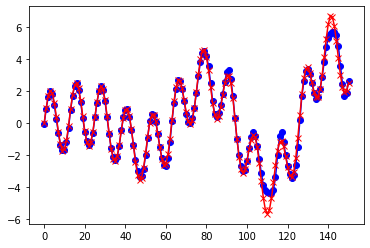

In [6]:
prediction = model.predict(X)

plt.plot(prediction, marker='o', color='blue')
plt.plot(y, marker='x', color='red')
plt.show()

Looks pretty good! This is of course just on the test data, so let's try this on the desired sequence.

In [7]:
X, y = generate_batched_series(15, 17)

prediction = model.predict(X)

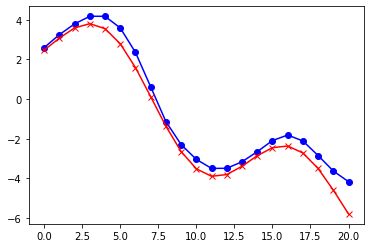

In [8]:
plt.plot(prediction, marker='o', color='blue')
plt.plot(y, marker='x', color='red')
plt.show()

This also looks pretty good! Showing the prediction on the interval from 15 to 17.

# Problem 3

Borrowing a lot of the code from lab, but stripped down to just the parts that we need:

In [9]:
import os

url = 'https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip'
fname = 'jena_climate_2009_2016.csv.zip'

zip_path = tf.keras.utils.get_file(
    origin=url,fname=fname,extract=True)
csv_path, _ = os.path.splitext(zip_path)

jenna = pd.read_csv(csv_path)
jenna.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [10]:
# We only want the data from 2014
datetimes = pd.to_datetime(jenna['Date Time'])
jenna = jenna.loc[(datetimes >= '01.01.2014') & (datetimes <= '12.31.2014')]

temp_original = jenna['T (degC)'] # select the 'T (degC)' colums 
temp_original.index = jenna['Date Time'] # Assign 'Date Time' as index
temp_original.head() # check the first 5 lines of series

Date Time
01.01.2014 00:00:00   -0.12
01.01.2014 00:10:00   -0.11
01.01.2014 00:20:00   -0.07
01.01.2014 00:30:00   -0.07
01.01.2014 00:40:00    0.20
Name: T (degC), dtype: float64

Note that, compared to the lab notebook, I switched the train-test split to test-train, for convenience later on.

In [11]:
TEST_TRAIN_SPLIT = 10000

temp_original = temp_original.values # convert temperatures to numpy
temperature_mean = temp_original[:TEST_TRAIN_SPLIT].mean() 
temperature_std = temp_original[:TEST_TRAIN_SPLIT].std() # std of the training set
print('temperature_mean:', temperature_mean)
print('temperature_std:', temperature_std)

temp_norm = (temp_original-temperature_mean)/ temperature_std

temperature_mean: 3.692387
temperature_std: 4.425000909856517


In [12]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = [] 
    labels = [] 
    start_index = start_index + history_size 
    if end_index is None:
        end_index = len(dataset) - target_size 

    for i in range(start_index, end_index):
        indices = range(i-history_size, i) 
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])  
    return np.array(data), np.array(labels)

In [13]:
temp_past_history = 20
temp_future_target = 1

x_train, y_train = univariate_data(dataset = temp_norm, 
                                   start_index = TEST_TRAIN_SPLIT, 
                                   end_index = None,
                                   history_size = temp_past_history,
                                  target_size = temp_future_target)

x_val, y_val = univariate_data(dataset=temp_norm,
                                    start_index = 0,
                                    end_index = TEST_TRAIN_SPLIT,
                                     history_size = temp_past_history,
                                   target_size = temp_future_target)

In [14]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val = val.batch(BATCH_SIZE).repeat()

In [15]:
# use functional programming

# step 1: define layers
inputs = tf.keras.layers.Input(shape=x_train.shape[-2:],name='model_input')
lstm_01 = tf.keras.layers.LSTM(units = 8)
dense_01 =tf.keras.layers.Dense(units = 1, activation='tanh', name='dense_01')

# connect layers
x = lstm_01(inputs)
output = dense_01(x)

simple_lstm_model = tf.keras.Model(inputs=inputs, outputs=output, name = 'simple_lstm_model')
simple_lstm_model.compile(optimizer='adam', loss='mae')


EPOCHS = 100
# steps_per_epoch * batch_size = number_of_rows_in_train_data
STEPS_PER_EPOCH = TEST_TRAIN_SPLIT/BATCH_SIZE
simple_lstm_model.fit(train, epochs=EPOCHS,
                      steps_per_epoch=STEPS_PER_EPOCH,
                      validation_data=val, validation_steps=50,
                      verbose=0)

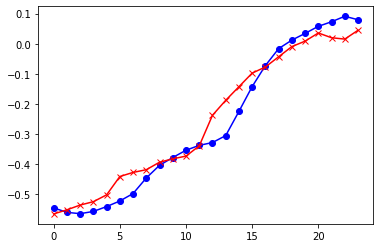

In [16]:
# Indices for January 1st
begin_index = 6*7
end_index = 6*11

predicted = simple_lstm_model.predict(x_val[begin_index:end_index])
expected = y_val[begin_index:end_index]

plt.plot(predicted, marker='o', color='blue')
plt.plot(expected, marker='x', color='red')
plt.show()

So, to reiterate, I inverted the order of the train-validation split in the Lab 7 notebook. That way we could use January 1st, 2014 and not worry about chasing down the right indices in the time series.

That said, our predicted values, in blue, look very close to our observed values, in red.

# Problem 4

Again, drawing largely from the lab notebook.

In [17]:
# Some helper functions to standardize all the values in our dataframes
def standardize_values(values):
    return (values-values.mean())/ values.std()

def standardize_dataframe(df, column_names):
    for column in column_names:
        df[column] = standardize_values(df[column])

In [18]:
df = pd.read_csv(csv_path)

col_names = df.columns.values.tolist()

standardize_dataframe(df, col_names[1:])
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,0.874229,-2.074010,-2.127439,-2.058613,1.049500,-1.323973,-1.535254,-0.780586,-1.536971,-1.539461,2.293603,-0.010271,-0.018931,-0.258921
1,01.01.2009 00:20:00,0.880211,-2.120310,-2.173297,-2.115071,1.055569,-1.336894,-1.556764,-0.782628,-1.555795,-1.560710,2.344885,-0.015008,-0.022553,-0.445812
2,01.01.2009 00:30:00,0.875425,-2.132182,-2.185056,-2.119528,1.085916,-1.339478,-1.559154,-0.784670,-1.559560,-1.563071,2.355891,-0.023106,-0.035159,-0.036268
3,01.01.2009 00:40:00,0.873032,-2.108438,-2.160363,-2.083871,1.104124,-1.333018,-1.544814,-0.786712,-1.544501,-1.548905,2.329625,-0.020814,-0.037042,0.268295
4,01.01.2009 00:50:00,0.873032,-2.103690,-2.156835,-2.079413,1.098055,-1.331726,-1.542424,-0.786712,-1.544501,-1.546544,2.324872,-0.021120,-0.035159,0.456339


In [19]:
df.corr()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
p (mbar),1.000000,-0.045375,-0.124718,-0.066755,-0.018352,-0.031546,-0.054370,-0.003401,-0.069762,-0.069804,0.307640,-0.005701,-0.007760,-0.063258
T (degC),-0.045375,1.000000,0.996827,0.895708,-0.572416,0.951113,0.867673,0.761744,0.866755,0.867177,-0.963410,-0.004689,-0.002871,0.038732
Tpot (K),-0.124718,0.996827,1.000000,0.894911,-0.567127,0.947293,0.866205,0.756962,0.866533,0.866955,-0.981345,-0.004195,-0.002224,0.043599
Tdew (degC),-0.066755,0.895708,0.894911,1.000000,-0.156615,0.799271,0.968344,0.435752,0.967599,0.968044,-0.885232,-0.008718,-0.009091,0.049877
rh (%),-0.018352,-0.572416,-0.567127,-0.156615,1.000000,-0.615842,-0.151494,-0.843835,-0.150841,-0.150969,0.514282,-0.005020,-0.009921,-0.015912
VPmax (mbar),-0.031546,0.951113,0.947293,0.799271,-0.615842,1.000000,0.824865,0.875588,0.824460,0.824493,-0.901536,-0.004018,-0.002213,-0.009583
VPact (mbar),-0.054370,0.867673,0.866205,0.968344,-0.151494,0.824865,1.000000,0.449154,0.999851,0.999856,-0.850241,-0.009600,-0.010316,0.018418
VPdef (mbar),-0.003401,0.761744,0.756962,0.435752,-0.843835,0.875588,0.449154,1.000000,0.448641,0.448689,-0.698290,0.001852,0.005317,-0.030881
sh (g/kg),-0.069762,0.866755,0.866533,0.967599,-0.150841,0.824460,0.999851,0.448641,1.000000,0.999997,-0.853325,-0.009479,-0.010163,0.019376
H2OC (mmol/mol),-0.069804,0.867177,0.866955,0.968044,-0.150969,0.824493,0.999856,0.448689,0.999997,1.000000,-0.853769,-0.009477,-0.010158,0.019607


With our normalized values, we can run the `pandas` correlation function to see variable correlations.

From this, we can see that "Tpot" most strongly, positively correlates with "T", and that "rho" most strongly, negatively correlates with "T".

In [20]:
dataset_norm = df.values

# Generating the column pairs we'll use to train
t_tpot = np.transpose(np.array([dataset_norm[:,2], dataset_norm[:,3]]))
t_rho = np.transpose(np.array([dataset_norm[:,2], dataset_norm[:,11]]))

In [21]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []
    start_index = start_index + history_size
    
    if end_index is None:
        end_index = len(dataset) - target_size
    
    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step) 
        
        data.append(dataset[indices])
        
        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])
    
    return np.array(data), np.array(labels)

In [22]:
past_history = 20
future_target = 1
STEP = 6

def train_val_data(dataset):
    x_train, y_train = multivariate_data(
                                    dataset= dataset,
                                    target = dataset[:, 1], 
                                    start_index = TEST_TRAIN_SPLIT,
                                    end_index = None, 
                                    history_size = past_history,
                                    target_size = future_target, 
                                    step = STEP,
                                    single_step=False)
    
    x_val, y_val = multivariate_data(
                            dataset= dataset, 
                            target = dataset[:, 1],
                            start_index = 0, 
                             end_index = TEST_TRAIN_SPLIT, 
                            history_size = past_history,
                            target_size = future_target, 
                            step = STEP,
                            single_step=False)
    
    x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
    y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
    x_val = tf.convert_to_tensor(x_val, dtype=tf.float32)
    y_val = tf.convert_to_tensor(y_val, dtype=tf.float32)
    
    train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

    val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
    val_data = val_data.batch(BATCH_SIZE).repeat()
    
    return (x_train, y_train, x_val, y_val, train_data, val_data)

So, we can use the big function above to generate all the data we need, first for our data containing "T" and "Tpot" (hence the `tt` prefix).

In [23]:
tt_x_train, tt_y_train, tt_x_val, tt_y_val, tt_train_data, tt_val_data = train_val_data(t_tpot)

In [24]:
# Step 1: define layers
multi_step_input = tf.keras.layers.Input(shape=tt_x_train.shape[-2:],name='model_input')
multi_step_lstm_01 = tf.keras.layers.LSTM(units = 32, return_sequences=True)
multi_step_lstm_02 = tf.keras.layers.LSTM(units = 16, activation='relu')
multi_step_dense_01 =tf.keras.layers.Dense(units = 72, name='dense_01') # we get 72 outputs

# Step 2: connect layers
x = multi_step_lstm_01(multi_step_input)
x = multi_step_lstm_02(x)
multi_output = multi_step_dense_01(x)

# Step 3: create model
multi_step_model = tf.keras.Model(inputs=multi_step_input, 
                                   outputs=multi_output, name = 'multi_lstm_model')
multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

multi_step_history = multi_step_model.fit(tt_train_data, epochs=EPOCHS,
                                      steps_per_epoch=STEPS_PER_EPOCH,
                                      validation_data=tt_val_data,
                                      validation_steps=50, verbose=0)

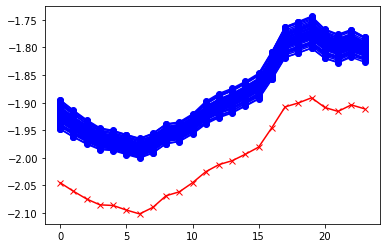

In [25]:
tt_predicted = multi_step_model.predict(tt_x_val[begin_index:end_index])
tt_expected = tt_y_val[begin_index-2:end_index-2]

plt.plot(tt_predicted, marker='o', color='blue')
plt.plot(tt_expected, marker='x', color='red')
plt.show()

This looks pretty good. I really don't know why the values seem to be biased, but after accounting for that mentally, it definitely seems like we're getting a stronger fit after 100 epochs than we were with the univariate model.

Now we do the same thing for the "T" and "rho" column pair.

In [26]:
tr_x_train, tr_y_train, tr_x_val, tr_y_val, tr_train_data, tr_val_data = train_val_data(t_rho)

In [27]:
multi_step_history = multi_step_model.fit(tr_train_data, epochs=EPOCHS,
                                      steps_per_epoch=STEPS_PER_EPOCH,
                                      validation_data=tr_val_data,
                                      validation_steps=50, verbose=0)

In [28]:
print(tr_y_val)

tf.Tensor(
[[2.4286866]
 [2.4194307]
 [2.4346902]
 ...
 [0.6613412]
 [0.607808 ]
 [0.6163133]], shape=(9980, 1), dtype=float32)


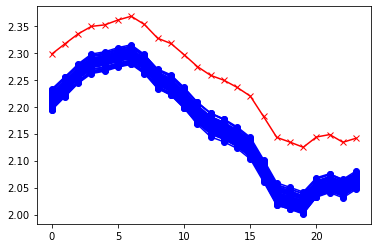

In [29]:
tr_predicted = multi_step_model.predict(tr_x_val[begin_index:end_index])
tr_expected = tr_y_val[begin_index-2:end_index-2]

plt.plot(tr_predicted, marker='o', color='blue')
plt.plot(tr_expected, marker='x', color='red')
plt.show()

This is also very good, which makes sense given that the correlation is high (just negative).

### Conclusion
So, I'm not sure why these graphs aren't all using the same expected values, but I'm really too burned out on index chasing here to hash it out. That said, the multivariate models clearly performed better than the univariate model.